In [1]:
import sys
sys.path.insert(0, "../source/")
sys.path.insert(0, "../models/AdvectionDiffusion/settings/AdvectionDiffusion_FEniCS")
sys.path.insert(0, "../models/AdvectionDiffusion/Navigators")
sys.path.insert(0, "../models/AdvectionDiffusion/Detectors")

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import fenics as dl

from InverseProblem import InverseProblem
from FOM_stationary import FOM_stationary as FOM
from Drone import Drone as Drone

# from DetectorPointwise import DetectorPointwise as Detector
# from DetectorTruncGaussian import DetectorTruncGaussian as Detector
# from DetectorApprox import DetectorTruncGaussian as Detector
# from DetectorApprox import DetectorGaussian as Detector
from DetectorApprox import DetectorPointwise as Detector
# from DetectorApprox import DetectorUniform as Detector
# from DetectorGaussian import DetectorGaussian as Detector
# from DetectorUniform import DetectorUniform as Detector

from NavigationCircle import NavigationCircle as Navigation
from NavigationFreePath import NavigationFreePath as Navigation
from OEDUtility import OEDUtility

import cyipopt
# import jax
# jax.config.update("jax_enable_x64", True)
# import jax.numpy as jnp

%load_ext autoreload
%autoreload 2

import time
tStart_notebook = time.time()

In [2]:
n_para = 5
var_prior = 1 # set to a high value (1e+6) to test convergence in noise-free situations

n_test = 100 # resolution for 1D plots
n_test_2d = 60 # resolution for 2D plots (50: ~1 min runtime for dt = 0.01)

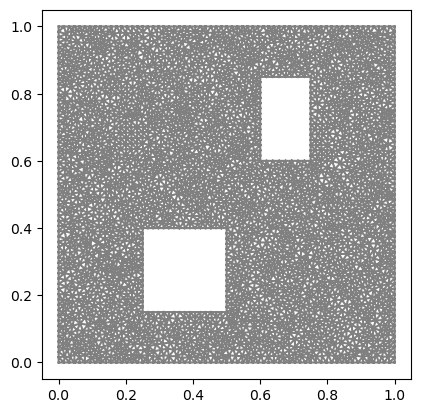

In [3]:
fom = FOM(mesh_shape='houses', polyDim=2, meshDim=50)
dl.plot(fom.mesh);

In [4]:
para = np.ones((n_para,))
# para_true = np.random.uniform(size = para.shape)

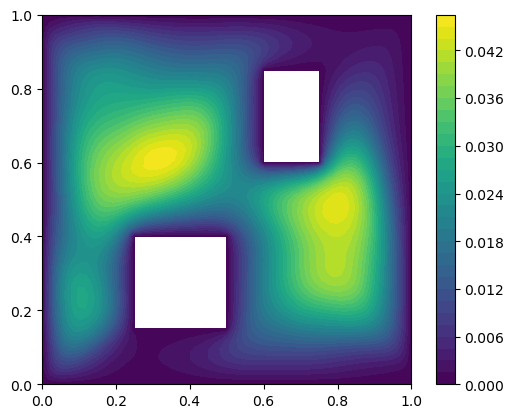

In [5]:
# state_true = fom.solve(parameter=para_true)
state = fom.solve(parameter=para)
fom.plot(state);

# state = fom.solve(parameter=para)
# fom.plot(state);

In [6]:
prior_mean = np.zeros((n_para,))
prior_covar = var_prior*np.eye(n_para)
fom.set_prior(prior_mean=prior_mean, prior_covar=prior_covar)

In [7]:
grid_t_drone = np.linspace(0, 4, 401)
navigation = Navigation(grid_t = grid_t_drone)
detector = Detector(fom, radius=0.1, sigma=0.025, resolution=100)
drone = Drone(detector=detector, navigation=navigation, fom=fom)

In [8]:
# user setting (for trying out different controls)
alpha = np.hstack(
            (np.linspace(0.5, 0.9, grid_t_drone.shape[0]), np.linspace(0.1, 0.4, grid_t_drone.shape[0]))
        )

# compute flight
flight = drone.plan_flight(alpha=alpha, grid_t=grid_t_drone)  # Flight object
flightpath, grid_t_drone = flight.flightpath, flight.grid_t  # path and its time discretization

In [9]:
inversion = InverseProblem(fom, drone)

In [10]:
measurements = drone.measure(state=state, flight=flight)

In [11]:
utility = OEDUtility(inversion)

In [12]:
import numpy as np

def arc_length_interpolation(vertices, n_points):
    # Calculate arc length between each pair of vertices
    distances = np.sqrt(np.sum(np.diff(vertices, axis=0)**2, axis=1))
    cumulative_distances = np.insert(np.cumsum(distances), 0, 0)
    total_length = cumulative_distances[-1]
    
    # Generate evenly spaced points along the arc length
    even_spaced_points = np.linspace(0, total_length, n_points)
    
    # Interpolate points
    interp_points = np.zeros((n_points, vertices.shape[1]))
    for i in range(vertices.shape[1]):
        interp_points[:, i] = np.interp(even_spaced_points, cumulative_distances, vertices[:, i])
    
    return interp_points

# Example usage
vertices = np.array([[0, 0], [1, 2], [2, 0], [0,1]])
n_points = 100
points = arc_length_interpolation(vertices, n_points)


In [13]:
from Optimization.DAE import Objective as objective_class

vertices = np.array([[0.7, 0.3], [0.5, 0.5], [0.2, 0.5], [0.1,0.1]])


problem_obj = objective_class(grid_t_drone, utility, inversion, 
                              piecewise_constant=None,
                              use_exact_DAE = False,
                              circle_mode = False,
                              enforce_initial_position = False,
                              # enforce_initial_position = True,
                              enforce_final_position = False,
                              # enforce_final_position = True,
                              periodic = False,
                              reg_strength = 1e-5,
                              OED_utility_mode = "D",
                              # OED_utility_mode = "mix",
                              # OED_mix = {"A": 1e-2, "E": 1.0},
                              # v_lower = 0.1,
                              # v_upper = 3,
                              acc_lower = -np.inf,
                              acc_upper = np.inf,
                              # omega_upper = 100,
                              # omega_lower = -100,
                              omega_acc_upper = np.inf,
                              omega_acc_lower = -np.inf,
                              build_video = True,
                              x0 = vertices[0,0],
                              y0 = vertices[0,1],
                              x_final = vertices[-1,0],
                              y_final = vertices[-1,1],
                              # x0 = 0.1,
                              # y0 = 0.1,
                              # x_final = 0.7,
                              # y_final = 0.3,
                              obstacle_buffer = 0.0,
                              L = 3.0,
                             )

In [14]:
def make_initial_condition(points, grid_t, correct_theta:bool = True, compute_controls:bool =True):
    initial_x = points[:,0]
    initial_y = points[:,1]
    
    initial_theta = np.arctan2(np.diff(initial_y, append=0.),np.diff(initial_x, append=0.))  # potential discontinuities from atan2 range

    if correct_theta:
        # fix discontinuities
        for i in range(len(initial_theta) - 1):
            while np.abs(initial_theta[i] - initial_theta[i+1]) > np.pi:
                if initial_theta[i] - initial_theta[i+1] > np.pi:
                    initial_theta[i + 1] += 2*np.pi
                if initial_theta[i] - initial_theta[i+1] <= -np.pi:
                    initial_theta[i + 1] -= 2*np.pi
    if compute_controls:
        initial_v = np.sqrt(np.diff(initial_y, append=0.)**2 + np.diff(initial_x, append=0.)**2) / np.diff(grid_t, append=1.)
        initial_acc = np.diff(initial_v, append=0.)
        initial_omega = np.diff(initial_theta, append=0.)
        initial_omega_acc = np.diff(initial_omega, append = 0.)
    else:
        initial_v = np.ones(initial_x.shape)
        initial_acc = np.zeros(initial_x.shape)
        initial_omega = np.ones(initial_x.shape)
        initial_omega_acc = np.zeros(initial_x.shape)
    
    return np.concatenate((initial_x, initial_y, initial_theta, initial_v, initial_acc, initial_omega, initial_omega_acc), axis = 0)

In [15]:
# Set the initial guess for the decision variables
vertices = np.array([[0.7, 0.3], [0.5, 0.5], [0.2, 0.5], [0.1,0.1]])
# vertices = np.flipud(vertices)
# vertices = np.array([[0.1, 0.1], [0.1, 0.8], [0.6, 0.95], [0.9, 0.95], [0.9, 0.5], [0.7, 0.2], [0.5, 0.5]])
# vertices = np.array([[0.5, 0.5], [0.1, 0.8], [0.6, 0.95], [0.9, 0.95], [0.9, 0.5], [0.7, 0.2], [0.5, 0.5], [0.1, 0.5], [0.1, 0.1], [0.5, 0.1], [0.5, 0.5]])
points = arc_length_interpolation(vertices, problem_obj.NK)

x0 = make_initial_condition(points, grid_t_drone, correct_theta = True, compute_controls=True)

In [16]:
initial_x = 0.75/2 + 0.25 * np.cos(grid_t_drone/2)
initial_y = 0.55/2 + 0.25 * np.sin(grid_t_drone/2)

x0 = make_initial_condition(np.concatenate((initial_x[:, None], initial_y[:, None]), axis = 1), grid_t_drone, correct_theta = True, compute_controls=False)

In [17]:
x0

array([0.625     , 0.62499688, 0.6249875 , ..., 0.        , 0.        ,
       0.        ])

In [18]:
# Set the initial guess for the decision variables
vertices = np.array([[0.7, 0.3], [0.5, 0.5], [0.2, 0.5], [0.1,0.1]])
# vertices = np.flipud(vertices)
# vertices = np.array([[0.1, 0.1], [0.1, 0.8], [0.6, 0.95], [0.9, 0.95], [0.9, 0.5], [0.7, 0.2], [0.5, 0.5]])
# vertices = np.array([[0.5, 0.5], [0.1, 0.8], [0.6, 0.95], [0.9, 0.95], [0.9, 0.5], [0.7, 0.2], [0.5, 0.5], [0.1, 0.5], [0.1, 0.1], [0.5, 0.1], [0.5, 0.5]])
points = arc_length_interpolation(vertices, problem_obj.NK)

x0 = make_initial_condition(points, grid_t_drone, correct_theta = True, compute_controls=True)

In [19]:
# x0 = solution

In [20]:
(x, y, _theta, _v, _acc, _omega, _omega_acc) = problem_obj.var_splitter(x0)
p = problem_obj.inversion.compute_posterior(alpha=np.concatenate((x, y), axis=0), grid_t=problem_obj.grid_t)
data = problem_obj.inversion.drone.measure(problem_obj.inversion.drone.plan_flight(alpha=np.concatenate((x, y), axis=0), grid_t=problem_obj.grid_t), state=state)
print(p.compute_covariance())
print(p.compute_mean(data))

[[ 9.99294636e-01 -4.23440308e-05 -6.30416104e-05 -2.50818134e-04
  -1.08589895e-04]
 [-4.23440308e-05  9.99672751e-01 -1.05777911e-04 -1.47110338e-05
  -4.43442712e-06]
 [-6.30416104e-05 -1.05777911e-04  9.99946170e-01 -2.18315862e-05
  -5.44016501e-06]
 [-2.50818134e-04 -1.47110338e-05 -2.18315862e-05  9.99910630e-01
  -3.97362616e-05]
 [-1.08589895e-04 -4.43442712e-06 -5.44016501e-06 -3.97362616e-05
   9.99736224e-01]]
[0.00117016 0.00049452 0.00024992 0.00041647 0.00042198]


In [21]:
problem_obj.objective(x0)

0.9988540649410524

In [22]:
# x0 = solution

problem_obj.add_option("hessian_approximation", "limited-memory")
problem_obj.add_option("tol", 1e-3)
# problem_obj.add_option("max_iter", 3)
# problem_obj.add_option("derivative_test_print_all", "yes")
# problem_obj.add_option("derivative_test", "first-order")
# problem_obj.add_option("gradient_approximation", "finite-difference-values")
# Solve the problem
solution, info = problem_obj.solve(x0)
# solution, info = problem.solve(solution)

# Print the solution
# print(f"Solution: {solution}")
print(f"Objective value: {info['obj_val']}")
print(f"OED objective value: {problem_obj.OED_objective(solution)}")
# output the value of the trajectory whenever the gradient is evaluated to make a video
# (objective value; constraint violation)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:     6800
Number of nonzeros in inequality constraint Jacobian.:     2005
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     2807
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1604
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2000
Total number of inequality c

In [23]:
(x, y, _theta, _v, _acc, _omega, _omega_acc) = problem_obj.var_splitter(solution)
p = problem_obj.inversion.compute_posterior(alpha=np.concatenate((x, y), axis=0), grid_t=problem_obj.grid_t)
data = problem_obj.inversion.drone.measure(problem_obj.inversion.drone.plan_flight(alpha=np.concatenate((x, y), axis=0), grid_t=problem_obj.grid_t), state=state)
print(p.compute_covariance())
print(p.compute_mean(data))
print(f"OED objective value: {problem_obj.OED_objective(solution)}")

                        = 2.101

EXIT: Optimal Solution Found.
[[ 9.99608935e-01 -1.27173159e-05 -1.92442567e-05 -2.54753717e-04
  -9.45869004e-05]
 [-1.27173159e-05  9.99514143e-01 -1.38152177e-04 -5.80952358e-06
  -2.55400229e-06]
 [-1.92442567e-05 -1.38152177e-04  9.99942057e-01 -9.01776200e-06
  -3.41348069e-06]
 [-2.54753717e-04 -5.80952358e-06 -9.01776200e-06  9.99722023e-01
  -4.93049373e-05]
 [-9.45869004e-05 -2.55400229e-06 -3.41348069e-06 -4.93049373e-05
   9.99857495e-01]]
[0.00077237 0.00064509 0.00022777 0.00059686 0.00029236]
OED objective value: 0.9986452304610339


In [24]:
# prior_mean = p.compute_mean(data)
# prior_covar = p.compute_covariance()
# fom.set_prior(prior_mean=prior_mean, prior_covar=prior_covar)

In [25]:
print(f"OED objective value: {problem_obj.OED_objective(solution)}")

OED objective value: 0.9986452304610339


100%|███████████████████████████████████████| 201/201 [00:00<00:00, 1037.17it/s]


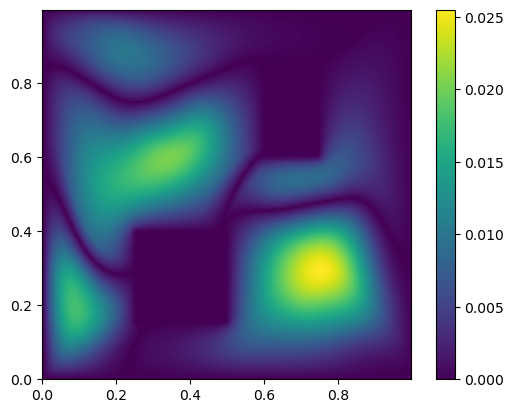

In [26]:
from tqdm import trange
x = np.linspace(0.001, 1, 201)-0.001
y = np.linspace(0.001, 1, 201)-0.001
A = np.zeros((len(x), len(y)))
B = np.zeros((len(x), len(y), len(inversion.states)))

eval_mode = list(inversion.states[0].convolution.keys())[0]
for k, basis_state in enumerate(inversion.states):
    for i in trange(len(x)):
        for j in range(len(y)):
            A[i,j] = basis_state.convolution[eval_mode](np.array([[x[i], y[j]]]))[0]
    B[:,:,k] = np.flipud(A.T)
    # plt.figure()
    # plt.imshow(np.flipud(A.T))
B = np.sort(B, axis = -1)
plt.figure()
plt.imshow(np.abs(B[:,:,-1] - B[:,:,-2]), extent = [np.min(x), np.max(x), np.min(y), np.max(y)])
# plt.imshow(np.abs(B[:,:,-1] - np.sum(B[:,:,:-2], axis = -1)) * ((B[:,:,-1] - np.sum(B[:,:,:-2], axis = -1)) > 0), extent = [np.min(x), np.max(x), np.min(y), np.max(y)])
plt.colorbar()

<Figure size 640x480 with 0 Axes>

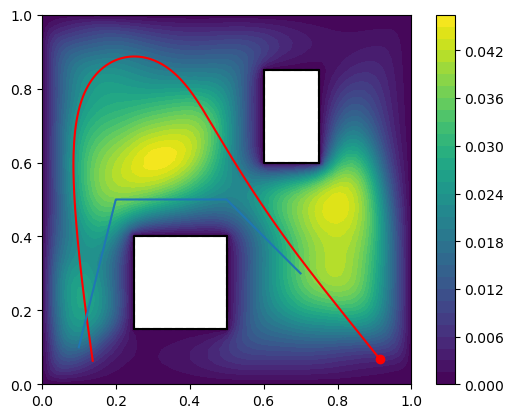

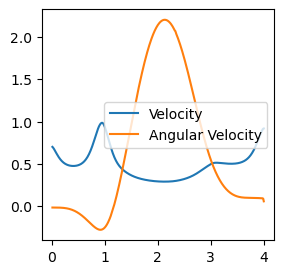

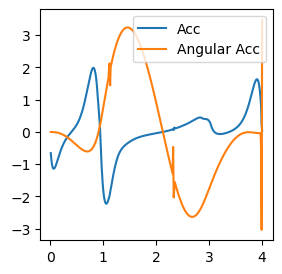

In [27]:
(x, y, theta, v, acc, omega, omega_acc) = problem_obj.var_splitter(solution)

(prev_x, prev_y, prev_theta, prev_v, prev_acc, prev_omega, prev_omega_acc) = problem_obj.var_splitter(solution)
prev_grid_t = grid_t_drone

plt.figure()
fom.plot(state)
# fom.plot(inversion.states[0])
# plt.imshow(np.abs(B[:,:,-1] - B[:,:,-2]), extent = [0, 1, 0, 1])
# fom.plot(fom.assemble_forcing(para_true))
plt.plot(x, y, label="Optimized path", color="red")
# plt.scatter(x, y, marker='d')
plt.scatter(x[0], y[0], marker='o', color="red")
# plt.scatter(problem_obj.x0, problem_obj.y0, marker='*')
plt.xlim([-0,1])
plt.ylim([-0,1])


(initial_x, initial_y, _, _, _, _, _) = problem_obj.var_splitter(x0)
plt.plot(initial_x, initial_y, label="Initial path")

if problem_obj.obstacle_shape == "circle":
    # circle
    t = np.linspace(0, 2*np.pi, 100)
    for cx, cy, rx, ry in zip(problem_obj.cxs, problem_obj.cys, problem_obj.rxs, problem_obj.rys):
        plt.plot(rx*np.cos(t) + cx, ry*np.sin(t) + cy, 'k')

if problem_obj.obstacle_shape == "diamond":
    # diamond
    for cx, cy, rx, ry in zip(problem_obj.cxs, problem_obj.cys, problem_obj.rxs, problem_obj.rys):
        plt.plot([cx, cx + rx, cx, cx - rx, cx], [cy + ry, cy, cy - ry, cy, cy + ry], 'k')

if problem_obj.obstacle_shape == "square":
    # square
    for cx, cy, rx, ry in zip(problem_obj.cxs, problem_obj.cys, problem_obj.rxs, problem_obj.rys):
        plt.plot([cx + rx, cx + rx, cx - rx, cx - rx, cx + rx], [cy -ry, cy + ry, cy + ry, cy - ry, cy - ry], 'k')
    for cx, cy, rx, ry in zip(problem_obj.cxs, problem_obj.cys, problem_obj.rxs, problem_obj.rys):
        plt.plot([cx + rx + problem_obj.obstacle_buffer,
                  cx + rx + problem_obj.obstacle_buffer,
                  cx - rx - problem_obj.obstacle_buffer,
                  cx - rx - problem_obj.obstacle_buffer,
                  cx + rx + problem_obj.obstacle_buffer],
                 [cy - ry - problem_obj.obstacle_buffer,
                  cy + ry + problem_obj.obstacle_buffer,
                  cy + ry + problem_obj.obstacle_buffer,
                  cy - ry - problem_obj.obstacle_buffer,
                  cy - ry - problem_obj.obstacle_buffer], 'k--')

plt.figure(figsize=(3,3))
plt.plot(grid_t_drone[1:], v[1:], label="Velocity")
plt.plot(grid_t_drone[1:], omega[1:], label="Angular Velocity")
plt.legend()

plt.figure(figsize=(3,3))
plt.plot(grid_t_drone[1:], acc[1:], label="Acc")
plt.plot(grid_t_drone[1:], omega_acc[1:], label="Angular Acc")
plt.legend()

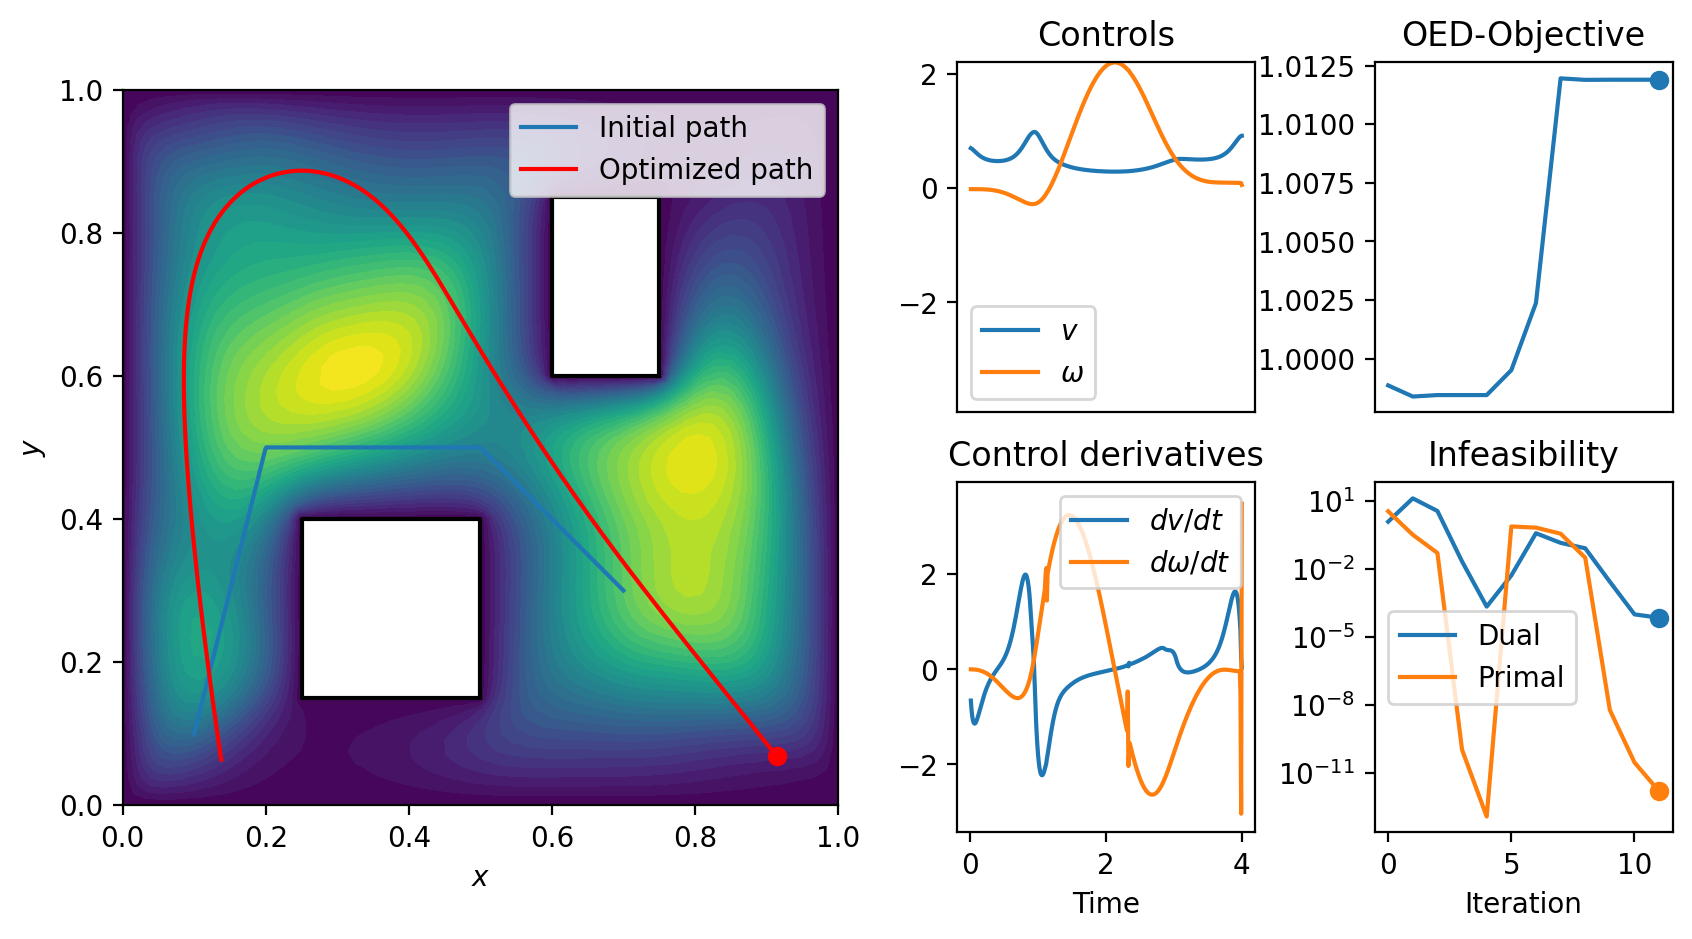

In [28]:
def generate_plot(frames, frame_index):
    fig = plt.figure(figsize=(10, 5), dpi=200)
    gs = fig.add_gridspec(nrows=2, ncols=4, width_ratios=[1, 1, 1, 1], wspace=0.4, hspace = 0.2)  # Add wspace for padding
    
    # Define subplots using indexing based on gs
    ax_A = fig.add_subplot(gs[0:2, 0:2])
    ax_B = fig.add_subplot(gs[0, 2])
    ax_C = fig.add_subplot(gs[1, 2], sharex=ax_B)
    ax_D = fig.add_subplot(gs[0, 3])
    ax_E = fig.add_subplot(gs[1, 3], sharex=ax_D)

    plt.sca(ax_A)
    fom.plot(state, ax = plt.gca())
    # plt.imshow(np.abs(B[:,:,-1] - B[:,:,-2]), extent = [0, 1, 0, 1])
    cxs = [(0.5 + 0.25) / 2, (0.75 + 0.6) / 2]
    cys = [(0.4 + 0.15) / 2, (0.85 + 0.6) / 2]
    rxs = [(0.5 - 0.25) / 2, (0.75 - 0.6) / 2]
    rys = [(0.4 - 0.15) / 2, (0.85 - 0.6) / 2]
    # square obstacles
    for cx, cy, rx, ry in zip(cxs, cys, rxs, rys):
        plt.plot([cx + rx, cx + rx, cx - rx, cx - rx, cx + rx], [cy -ry, cy + ry, cy + ry, cy - ry, cy - ry], "k")
        if problem_obj.obstacle_buffer > 0.0:
            plt.plot([cx + rx + problem_obj.obstacle_buffer,
                      cx + rx + problem_obj.obstacle_buffer,
                      cx - rx - problem_obj.obstacle_buffer,
                      cx - rx - problem_obj.obstacle_buffer,
                      cx + rx + problem_obj.obstacle_buffer],
                     [cy - ry - problem_obj.obstacle_buffer,
                      cy + ry + problem_obj.obstacle_buffer,
                      cy + ry + problem_obj.obstacle_buffer,
                      cy - ry - problem_obj.obstacle_buffer,
                      cy - ry - problem_obj.obstacle_buffer], 'k--')

    (initial_x, initial_y) = (frames[0]["variables"]["x"], frames[0]["variables"]["y"])
    plt.plot(initial_x, initial_y, label="Initial path")
    
    x = frames[frame_index]["variables"]["x"]
    y = frames[frame_index]["variables"]["y"]
    plt.plot(x, y, label="Optimized path", color="red")
    plt.scatter(x[0], y[0], marker='o', color="red")
    plt.legend()
    plt.xlabel("$x$")
    plt.ylabel("$y$")

    plt.sca(ax_B)
    plt.title("Controls")
    plt.plot(grid_t_drone[1:], frames[frame_index]["variables"]["v"][1:], label = "$v$")
    plt.plot(grid_t_drone[1:], frames[frame_index]["variables"]["omega"][1:], label = "$\omega$")
    max_val = max(max(np.max(frames[i]["variables"]["v"]) for i in frames),
                  max(np.max(frames[i]["variables"]["omega"]) for i in frames))
    min_val = min(min(np.min(frames[i]["variables"]["v"]) for i in frames),
                  min(np.min(frames[i]["variables"]["omega"]) for i in frames))
    plt.ylim([min_val, max_val])
    plt.legend()

    plt.sca(ax_C)
    plt.plot(grid_t_drone[1:], frames[frame_index]["variables"]["acc"][1:], label = "$dv/dt$")
    plt.plot(grid_t_drone[1:], frames[frame_index]["variables"]["omega_acc"][1:], label = "$d\omega / dt$")
    max_val = max(max(np.max(frames[i]["variables"]["acc"]) for i in frames),
                  max(np.max(frames[i]["variables"]["omega_acc"]) for i in frames))
    min_val = min(min(np.min(frames[i]["variables"]["acc"]) for i in frames),
                  min(np.min(frames[i]["variables"]["omega_acc"]) for i in frames))
    plt.ylim([min_val, max_val])
    plt.xlabel("Time")
    plt.title("Control derivatives")
    plt.legend()

    plt.sca(ax_D)
    objective_values = []
    for i in frames:
        objective_values.append(frames[i]["obj_value"])
    plt.plot(objective_values)
    plt.scatter([frame_index],[objective_values[frame_index]])
    plt.title("OED-Objective")

    plt.sca(ax_E)
    dual_inf = []
    for i in frames:
        dual_inf.append(frames[i]["inf_du"])
    plt.plot(dual_inf, label = "Dual")
    plt.scatter([frame_index],[dual_inf[frame_index]])
    plt.yscale("log")

    plt.sca(ax_E)
    primal_inf = []
    for i in frames:
        primal_inf.append(frames[i]["inf_pr"])
    plt.plot(primal_inf, label = "Primal")
    plt.scatter([frame_index],[primal_inf[frame_index]])
    plt.yscale("log")
    plt.title("Infeasibility")
    plt.xlabel("Iteration")
    plt.legend()

    ax_B.get_xaxis().set_visible(False)
    ax_D.get_xaxis().set_visible(False)
    
    
generate_plot(problem_obj.video_frames, len(problem_obj.video_frames) - 1)

In [29]:
from tqdm.notebook import tqdm
raster_states = []
raster_resolution = 100
x = np.linspace(0, 1, raster_resolution)
y = np.linspace(0, 1, raster_resolution)
X,Y = np.meshgrid(x, y, indexing='ij')
for s in inversion.states:
    raster_state = np.zeros((raster_resolution, raster_resolution))
    for ii, xx in enumerate(tqdm(x)):
        for jj, yy in enumerate(y):
            try:
                raster_state[ii,jj] = s.state((xx,yy))
            except:
                pass
    raster_states.append(raster_state)

raster_states = np.array(raster_states)
raster_states = np.moveaxis(raster_states, 0, -1)

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [ ]:
plt.imshow(np.flipud(raster_states[:,:,0]))

In [ ]:
raster_true = np.dot(raster_states, para)

In [ ]:
# def generate_plot(frames, frame_index):
#     fig = plt.figure(figsize=(10, 5), dpi=200)
#     gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=[1, 1], wspace=0.4, hspace = 0.2)  # Add wspace for padding
    
#     # Define subplots using indexing based on gs
#     ax_A = fig.add_subplot(gs[0, 0])
#     ax_B = fig.add_subplot(gs[0, 1])

#     plt.sca(ax_A)
#     # fom.plot(state, ax = plt.gca())
#     x = np.linspace(0, 1, raster_resolution)
#     y = np.linspace(0, 1, raster_resolution)
#     X,Y = np.meshgrid(x, y, indexing='ij')
#     # plt.pcolor(X, Y, raster_states[0], vmin=0, vmax=1)
#     plt.pcolor(X, Y, raster_true)
#     plt.clim(0,0.05)
#     # plt.colorbar()
#     plt.gca().set_aspect('equal')
#     # plt.imshow(np.abs(B[:,:,-1] - B[:,:,-2]), extent = [0, 1, 0, 1])
#     cxs = [(0.5 + 0.25) / 2, (0.75 + 0.6) / 2]
#     cys = [(0.4 + 0.15) / 2, (0.85 + 0.6) / 2]
#     rxs = [(0.5 - 0.25) / 2, (0.75 - 0.6) / 2]
#     rys = [(0.4 - 0.15) / 2, (0.85 - 0.6) / 2]
#     # square obstacles
#     for cx, cy, rx, ry in zip(cxs, cys, rxs, rys):
#         plt.plot([cx + rx, cx + rx, cx - rx, cx - rx, cx + rx], [cy -ry, cy + ry, cy + ry, cy - ry, cy - ry], "k")
#         if problem_obj.obstacle_buffer > 0.0:
#             plt.plot([cx + rx + problem_obj.obstacle_buffer,
#                       cx + rx + problem_obj.obstacle_buffer,
#                       cx - rx - problem_obj.obstacle_buffer,
#                       cx - rx - problem_obj.obstacle_buffer,
#                       cx + rx + problem_obj.obstacle_buffer],
#                      [cy - ry - problem_obj.obstacle_buffer,
#                       cy + ry + problem_obj.obstacle_buffer,
#                       cy + ry + problem_obj.obstacle_buffer,
#                       cy - ry - problem_obj.obstacle_buffer,
#                       cy - ry - problem_obj.obstacle_buffer], 'k--')

#     (initial_x, initial_y) = (frames[0]["variables"]["x"], frames[0]["variables"]["y"])
#     plt.plot(initial_x, initial_y, label="Initial path")
    
#     x = frames[frame_index]["variables"]["x"]
#     y = frames[frame_index]["variables"]["y"]
#     plt.plot(x, y, label="Optimized path", color="red")
#     plt.scatter(x[0], y[0], marker='o', color="red")
#     plt.legend()
#     plt.xlabel("$x$")
#     plt.ylabel("$y$")
#     plt.title("Observations of true state")

#     plt.sca(ax_B)
#     p = problem_obj.inversion.compute_posterior(alpha=np.concatenate((x, y), axis=0), grid_t=problem_obj.grid_t)
#     data = problem_obj.inversion.drone.measure(problem_obj.inversion.drone.plan_flight(alpha=np.concatenate((x, y), axis=0), grid_t=problem_obj.grid_t), state=state)
#     post_mean = p.compute_mean(data)

#     # plt.pcolor(X, Y, raster_states[0], vmin=0, vmax=1)
#     plt.pcolor(X, Y, np.dot(raster_states, post_mean))
#     plt.clim(0,0.05)

#     # square obstacles
#     for cx, cy, rx, ry in zip(cxs, cys, rxs, rys):
#         plt.plot([cx + rx, cx + rx, cx - rx, cx - rx, cx + rx], [cy -ry, cy + ry, cy + ry, cy - ry, cy - ry], "k")
#         if problem_obj.obstacle_buffer > 0.0:
#             plt.plot([cx + rx + problem_obj.obstacle_buffer,
#                       cx + rx + problem_obj.obstacle_buffer,
#                       cx - rx - problem_obj.obstacle_buffer,
#                       cx - rx - problem_obj.obstacle_buffer,
#                       cx + rx + problem_obj.obstacle_buffer],
#                      [cy - ry - problem_obj.obstacle_buffer,
#                       cy + ry + problem_obj.obstacle_buffer,
#                       cy + ry + problem_obj.obstacle_buffer,
#                       cy - ry - problem_obj.obstacle_buffer,
#                       cy - ry - problem_obj.obstacle_buffer], 'k--')

#     plt.gca().set_aspect('equal')
#     # plt.colorbar()
#     plt.xlabel("$x$")
#     plt.ylabel("$y$")
#     plt.title("Posterior mean state")
    
    
    
# generate_plot(problem_obj.video_frames, 10)

In [ ]:
import matplotlib.pyplot as plt
import os
from moviepy.editor import ImageSequenceClip
from tqdm import tqdm

for filename in os.listdir("frames"):
    file_path = os.path.join("frames", filename)
    try:
        if os.path.isfile(file_path):  # Check if it's a file
            os.remove(file_path)
    except OSError as e:
        print(f"Error removing file: {filename} ({e})")

# Create a directory to store the frames (optional)
os.makedirs("frames", exist_ok=True)  # Create directory if it doesn't exist

# Generate frames and save them as PNGs
for i, frame in tqdm(problem_obj.video_frames.items()):
    generate_plot(problem_obj.video_frames, i)
    plt.savefig(f"frames/frame_{i + 1:04d}.png")
    # plt.show()
    plt.clf()  # Clear the figure to avoid overlapping plots

In [ ]:
import os
from moviepy.editor import ImageSequenceClip
# Use moviepy to combine the frames into a video (replace 'my_video.mp4' with your desired filename)

clip = ImageSequenceClip(os.path.abspath("frames"), fps=30)
clip.write_videofile("my_video.mp4")

print("Video frames generated and saved as my_video.mp4")

In [ ]:
import imageio

src_dir = "my_video.mp4"
dst_dir = "my_video.avi"

reader = imageio.get_reader(src_dir)
fps = reader.get_meta_data()['fps']
writer = imageio.get_writer(dst_dir, fps=fps)

for im in reader:
    writer.append_data(im[:, :, :])
writer.close()

In [ ]:
clip.write_gif("my_video.gif")

In [ ]:
import pickle as pkl
with open('my_video.pkl', 'wb') as f:
    pkl.dump(problem_obj.video_frames, f)

In [ ]:
inversion.set_noise_model(c_scaling = 1e+6, c_diffusion=0)
inversion.sample_noise() # 😑

In [ ]:
from InverseProblemBayesNeumann import InverseProblemBayesNeumann
from InverseProblemBayesDirichlet import InverseProblemBayesDirichlet

a = InverseProblemBayesNeumann(fom, drone)
a.set_noise_model(c_scaling = 1e+5, c_diffusion=0)
noise = a.sample_noise(n_samples = 1)
plt.figure()
plt.plot(noise)